In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
# Define file paths relative to the project root
raw_data_path = '../data/raw/S5P_AQI_Data_Delhi_NCR_2020_Present_NRTI.csv'
processed_data_path = '../data/processed/S5P_NRTI_Filled.csv'

In [6]:
# Load the raw satellite data
try:
    s5p_df = pd.read_csv(raw_data_path)
    print("Raw S5P data loaded successfully.")
    print(f"Shape: {s5p_df.shape}")
except FileNotFoundError:
    print(f"Error: Raw data file not found at {raw_data_path}")
    # Stop execution if file not found
    raise

Raw S5P data loaded successfully.
Shape: (16153, 7)


In [7]:
print("\n--- Basic Info ---")
s5p_df.info()


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16153 entries, 0 to 16152
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           16153 non-null  object 
 1   NO2            7656 non-null   float64
 2   SO2            7708 non-null   float64
 3   CO             7449 non-null   float64
 4   O3             10806 non-null  float64
 5   Aerosol_Index  10994 non-null  float64
 6   location       16153 non-null  object 
dtypes: float64(5), object(2)
memory usage: 883.5+ KB


In [8]:
print("\n--- First 5 Rows ---")
print(s5p_df.head())


--- First 5 Rows ---
         date       NO2       SO2        CO        O3  Aerosol_Index  \
0  01-01-2020       NaN       NaN       NaN       NaN            NaN   
1  02-01-2020  0.000191 -0.000433  0.048550  0.164568      -1.098919   
2  03-01-2020  0.000143  0.000546  0.041712  0.139937      -1.405038   
3  04-01-2020       NaN -0.000315  0.044633  0.137429      -1.210190   
4  05-01-2020  0.000143 -0.000531  0.045669  0.128115      -0.864201   

             location  
0  Anand Vihar, Delhi  
1  Anand Vihar, Delhi  
2  Anand Vihar, Delhi  
3  Anand Vihar, Delhi  
4  Anand Vihar, Delhi  


In [9]:
print("\n--- Summary Statistics ---")
# Describe only numeric columns, handling potential non-numeric parsing issues
print(s5p_df.describe(include=[np.number]))


--- Summary Statistics ---
               NO2          SO2           CO            O3  Aerosol_Index
count  7656.000000  7708.000000  7449.000000  10806.000000   10994.000000
mean      0.000146     0.000145     0.041423      0.126898      -0.247853
std       0.000114     0.000588     0.007013      0.006808       0.964272
min       0.000015    -0.000998     0.023917      0.105325      -5.423089
25%       0.000083    -0.000198     0.036805      0.122542      -0.970623
50%       0.000115     0.000074     0.039930      0.126296      -0.299222
75%       0.000168     0.000398     0.044738      0.130914       0.372394
max       0.001703     0.006777     0.087687      0.166354       4.218647


In [10]:
print("\n--- Check Unique Locations ---")
print(s5p_df['location'].unique())


--- Check Unique Locations ---
['Anand Vihar, Delhi' 'RK Puram, Delhi' 'Punjabi Bagh, Delhi'
 'Mandir Marg, Delhi' 'Vikas Sadan, Gurugram' 'Sector 51, Gurugram'
 'Sector 62, Noida' 'Sector 125, Noida']


In [11]:
# Convert 'date' column to datetime objects
try:
    s5p_df['date'] = pd.to_datetime(s5p_df['date'], dayfirst=True)
    print("Date column converted successfully with dayfirst=True.")
except ValueError as e:
    print(f"Error converting date column: {e}")
    print("Consider using format='mixed' or specifying a format if dates are inconsistent.")
    raise # Stop if conversion fails

Date column converted successfully with dayfirst=True.


In [12]:
# Sort data just in case
s5p_df.sort_values(by=['location', 'date'], inplace=True)

In [13]:
print("\n--- Data types after date conversion ---")
s5p_df.info()


--- Data types after date conversion ---
<class 'pandas.core.frame.DataFrame'>
Index: 16153 entries, 0 to 10096
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           16153 non-null  datetime64[ns]
 1   NO2            7656 non-null   float64       
 2   SO2            7708 non-null   float64       
 3   CO             7449 non-null   float64       
 4   O3             10806 non-null  float64       
 5   Aerosol_Index  10994 non-null  float64       
 6   location       16153 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1009.6+ KB


In [14]:
print("\n--- Missing Value Counts (Before Filling) ---")
missing_counts = s5p_df.isnull().sum()
print(missing_counts)


--- Missing Value Counts (Before Filling) ---
date                0
NO2              8497
SO2              8445
CO               8704
O3               5347
Aerosol_Index    5159
location            0
dtype: int64


In [15]:
print("\n--- Missing Value Percentages (Before Filling) ---")
missing_percentages = (s5p_df.isnull().sum() / len(s5p_df)) * 100
print(missing_percentages)


--- Missing Value Percentages (Before Filling) ---
date              0.000000
NO2              52.603232
SO2              52.281310
CO               53.884727
O3               33.102210
Aerosol_Index    31.938340
location          0.000000
dtype: float64


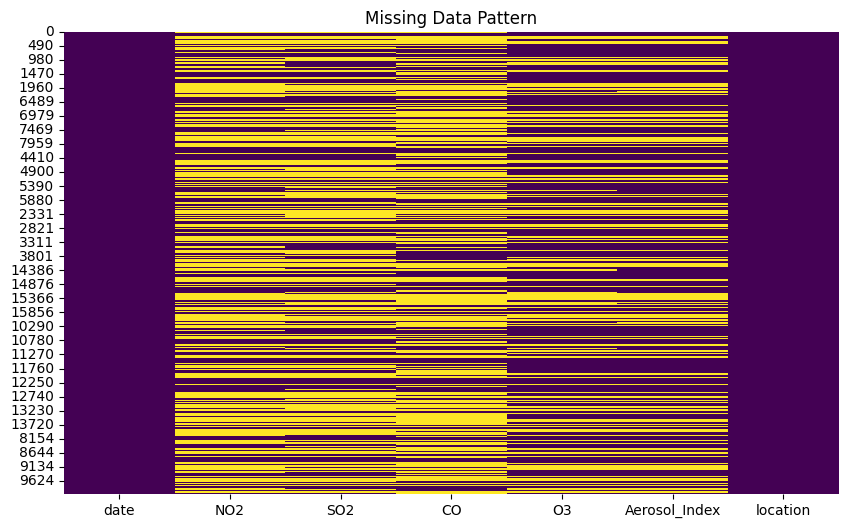

In [16]:
# Visualize missing data patterns if needed
plt.figure(figsize=(10, 6))
sns.heatmap(s5p_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern")
plt.show()

In [17]:
# Define pollutant columns to fill
pollutant_cols = ['NO2', 'SO2', 'CO', 'O3', 'Aerosol_Index']

In [18]:
# Convert pollutant columns to numeric, coercing errors to NaN
for col in pollutant_cols:
    s5p_df[col] = pd.to_numeric(s5p_df[col], errors='coerce')

In [19]:
print("\n--- Filling missing values using linear interpolation within each location group ---")

# --- Use transform instead of apply ---
# transform applies the function to each group and returns a Series/DataFrame
# with the same index as the original DataFrame, avoiding index mismatches.
s5p_filled_df = s5p_df.copy() # Work on a copy
s5p_filled_df[pollutant_cols] = s5p_filled_df.groupby('location')[pollutant_cols].transform(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
)
# --- End change ---


--- Filling missing values using linear interpolation within each location group ---


In [20]:
# Verify missing values after filling
print("\n--- Missing Value Counts (After Filling) ---")
print(s5p_filled_df.isnull().sum())


--- Missing Value Counts (After Filling) ---
date             0
NO2              0
SO2              0
CO               0
O3               0
Aerosol_Index    0
location         0
dtype: int64


In [21]:
# Check if any NaNs remain (might happen if a location has ALL NaNs for a column)
if s5p_filled_df[pollutant_cols].isnull().any().any():
    print("\nWarning: Some NaNs remain after interpolation.")
    print("This might occur if an entire location group had missing data.")
    # Fill remaining NaNs with 0 or a global mean/median if appropriate
    s5p_filled_df[pollutant_cols] = s5p_filled_df[pollutant_cols].fillna(0)

In [22]:
print("\n--- First 5 rows of filled data ---")
print(s5p_filled_df.head())


--- First 5 rows of filled data ---
        date       NO2       SO2        CO        O3  Aerosol_Index  \
0 2020-01-01  0.000191 -0.000433  0.048550  0.164568      -1.098919   
1 2020-01-02  0.000191 -0.000433  0.048550  0.164568      -1.098919   
2 2020-01-03  0.000143  0.000546  0.041712  0.139937      -1.405038   
3 2020-01-04  0.000143 -0.000315  0.044633  0.137429      -1.210190   
4 2020-01-05  0.000143 -0.000531  0.045669  0.128115      -0.864201   

             location  
0  Anand Vihar, Delhi  
1  Anand Vihar, Delhi  
2  Anand Vihar, Delhi  
3  Anand Vihar, Delhi  
4  Anand Vihar, Delhi  


In [23]:
print(f"\n--- Saving processed data to: {processed_data_path} ---")


--- Saving processed data to: ../data/processed/S5P_NRTI_Filled.csv ---


In [24]:
os.makedirs(os.path.dirname(processed_data_path), exist_ok=True)

try:
    s5p_filled_df.to_csv(processed_data_path, index=False)
    print("Processed data saved successfully.")
except Exception as e:
    print(f"Error saving processed data: {e}")

Processed data saved successfully.


In [25]:
# Define file path relative to the notebooks folder
processed_data_path = '../data/processed/S5P_NRTI_Filled.csv'

# Load the processed satellite data
try:
    s5p_df = pd.read_csv(processed_data_path, parse_dates=['date']) # Load and parse dates
    print("Processed S5P data loaded successfully.")
    print(f"Shape: {s5p_df.shape}")
except FileNotFoundError:
    print(f"Error: Processed data file not found at {processed_data_path}")
    raise
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    raise

Processed S5P data loaded successfully.
Shape: (16153, 7)


In [26]:
units = { # Approximate units for labels
    'NO2': 'mol/m²',
    'SO2': 'mol/m²',
    'CO': 'mol/m²',
    'O3': 'mol/m²',
    'Aerosol_Index': 'Unitless Index'
}

In [27]:
print("\n--- Plotting Value Distributions for Each Pollutant ---")


--- Plotting Value Distributions for Each Pollutant ---


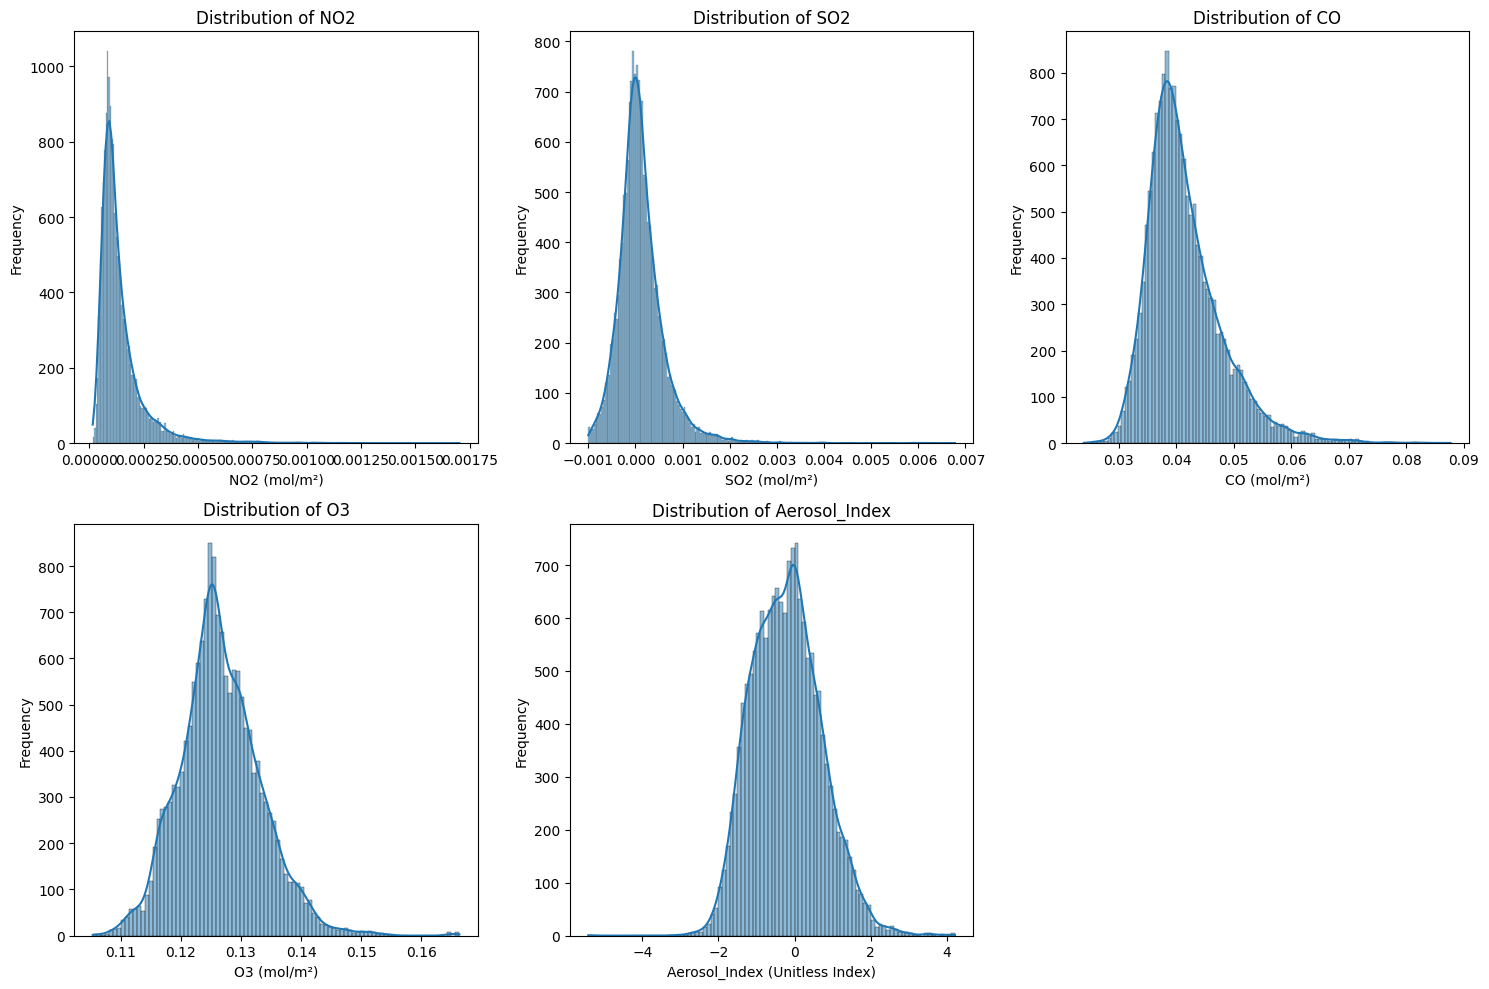

In [28]:
# Determine grid size for subplots (e.g., 2 rows, 3 columns)
n_cols = 3
n_rows = (len(pollutant_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, col in enumerate(pollutant_cols):
    ax = axes[i]
    if col in s5p_df.columns and pd.api.types.is_numeric_dtype(s5p_df[col]):
        sns.histplot(s5p_df[col].dropna(), kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(f'{col} ({units.get(col, "")})')
        ax.set_ylabel('Frequency')
    else:
        ax.set_title(f'{col} - Not Plotted (Non-numeric or Missing)')
        ax.axis('off') # Hide axis if column is not plotted

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Observations: Satellite Data Value Distributions

Based on the histograms and KDE plots:

* **$NO_2$ and $SO_2$:** Both show **highly right-skewed** (positively skewed) distributions. The vast majority of measurements are clustered at very low values (close to zero), with a long tail extending towards infrequent higher values. This is typical for pollutants with localized sources or episodic events.
* **$CO$:** This distribution is also **right-skewed**, but less extremely than $NO_2$ or $SO_2$. Values are centered around approximately 0.04 mol/m², with a noticeable tail towards higher concentrations.
* **$O_3$ and Aerosol Index:** These distributions appear much more **symmetrical and roughly resemble a normal distribution**.
    * $O_3$ is centered around approximately 0.13 mol/m².
    * Aerosol Index is centered around 0, with values extending both positively and negatively.

**Overall:** The gaseous pollutants directly linked to combustion ($NO_2$, $SO_2$, $CO$) show right-skewed distributions, indicating generally low background levels punctuated by higher concentration events or locations. Ozone and Aerosol Index exhibit more balanced, bell-shaped distributions across the dataset.

In [29]:
print("\n--- Summary Statistics for Pollutants ---")
print(s5p_df[pollutant_cols].describe())


--- Summary Statistics for Pollutants ---
                NO2           SO2            CO            O3  Aerosol_Index
count  16153.000000  16153.000000  16153.000000  16153.000000   16153.000000
mean       0.000143      0.000122      0.041474      0.126606      -0.209317
std        0.000113      0.000507      0.006588      0.006833       0.913639
min        0.000015     -0.000998      0.023917      0.105325      -5.423089
25%        0.000080     -0.000165      0.037056      0.122292      -0.887879
50%        0.000109      0.000053      0.040119      0.126060      -0.228919
75%        0.000164      0.000328      0.044579      0.130677       0.387767
max        0.001703      0.006777      0.087687      0.166354       4.218647


In [30]:
print("\n--- Plotting Value Distributions Across Locations ---")


--- Plotting Value Distributions Across Locations ---


In [31]:
s5p_df.reset_index(drop=True, inplace=True)

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_17368\2887709696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')


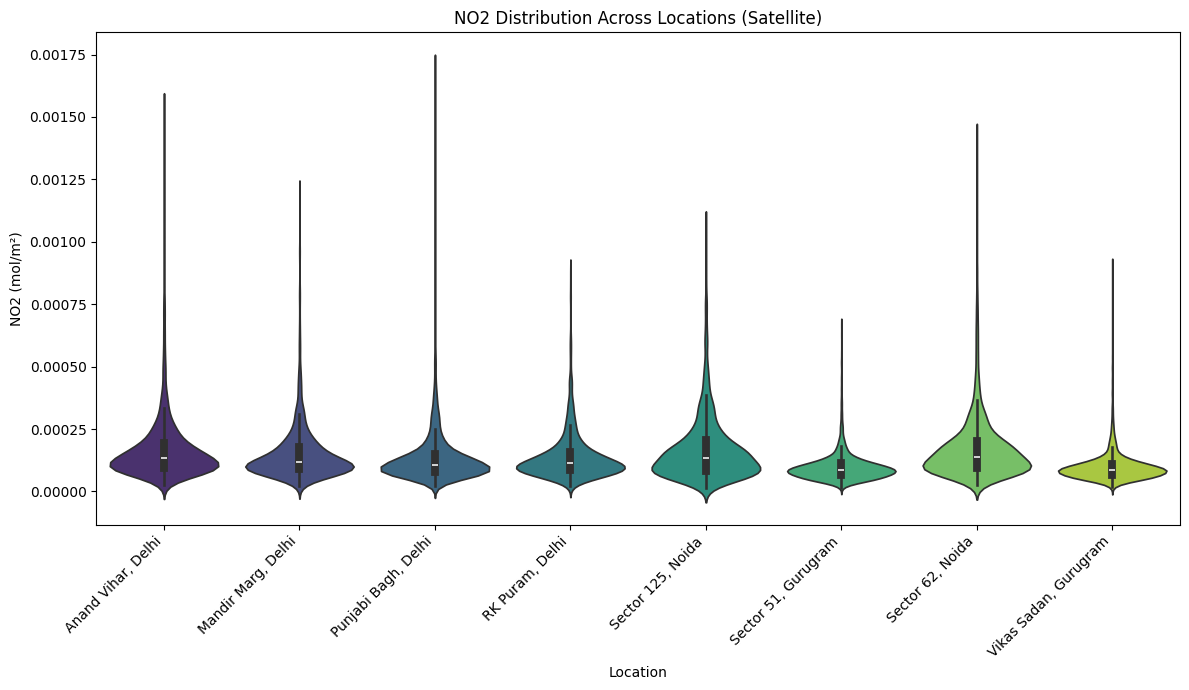

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_17368\2887709696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')


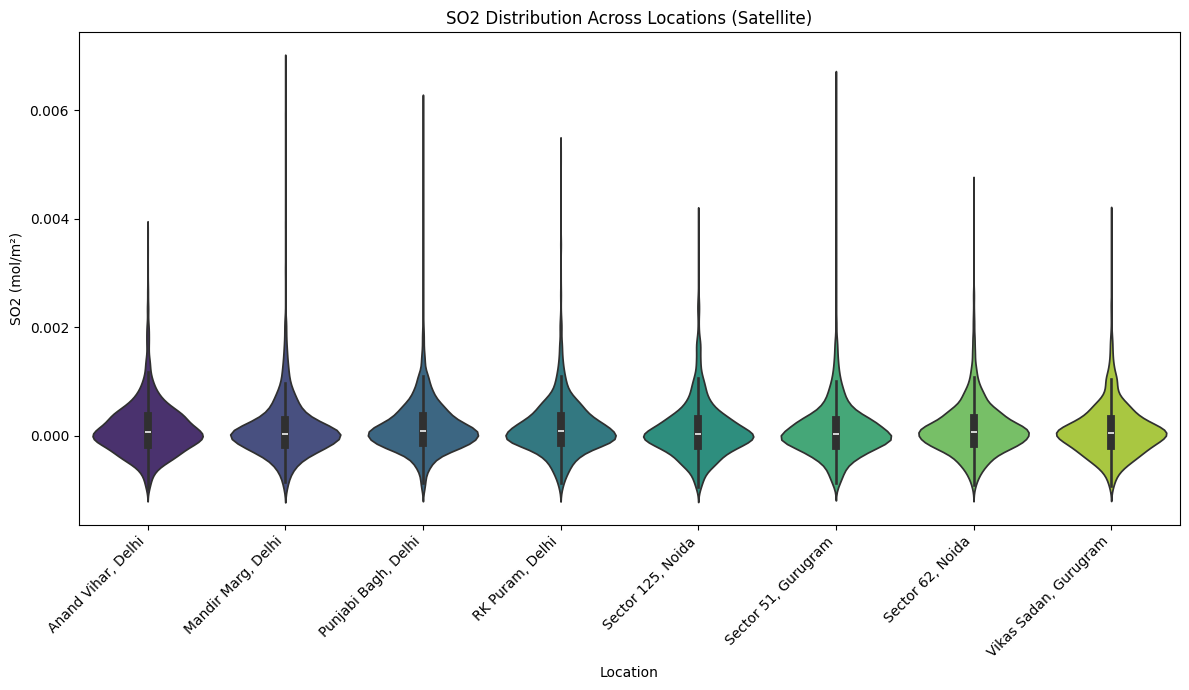

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_17368\2887709696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')


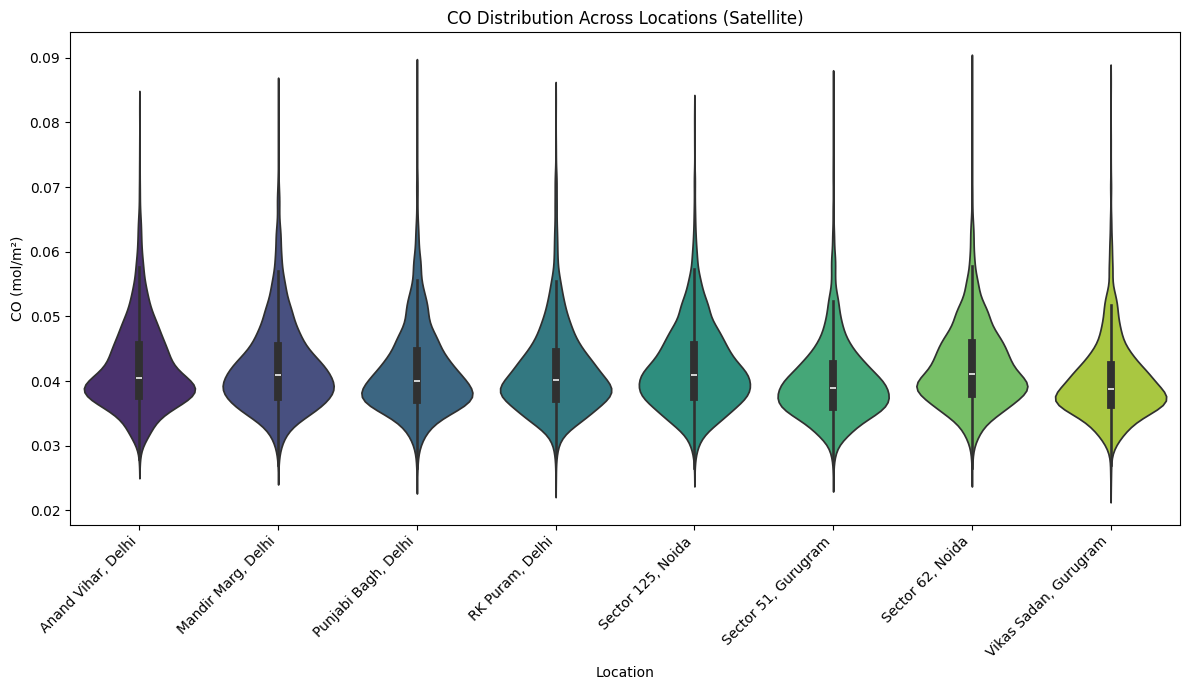

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_17368\2887709696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')


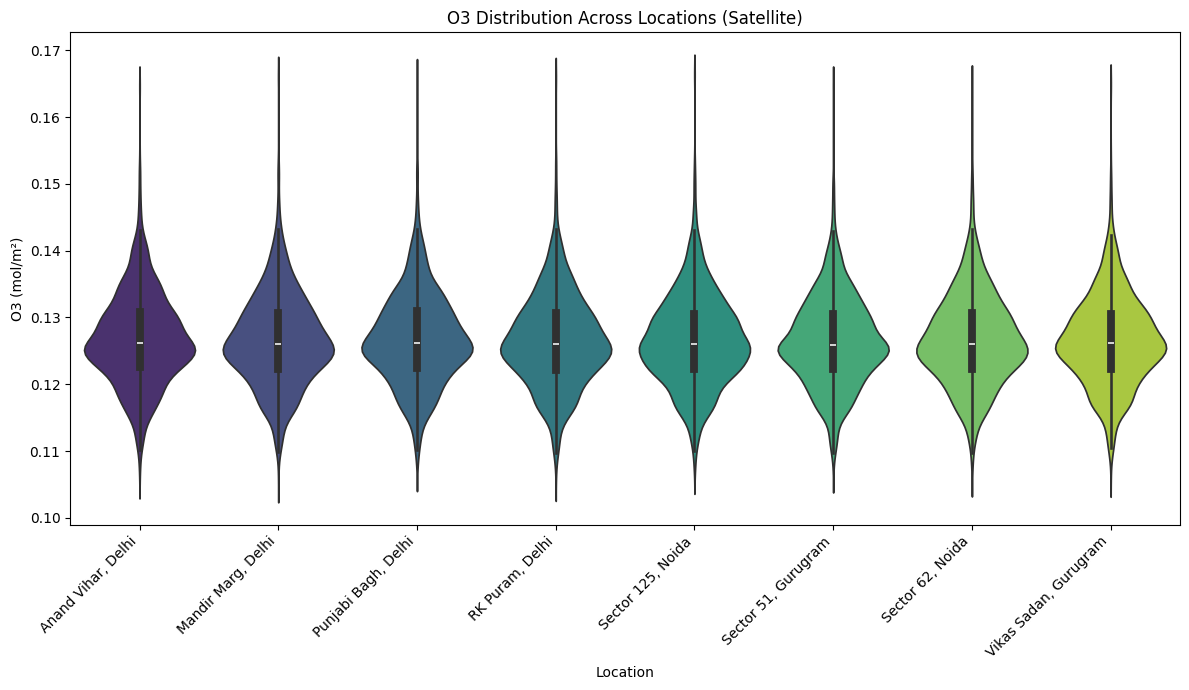

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_17368\2887709696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')


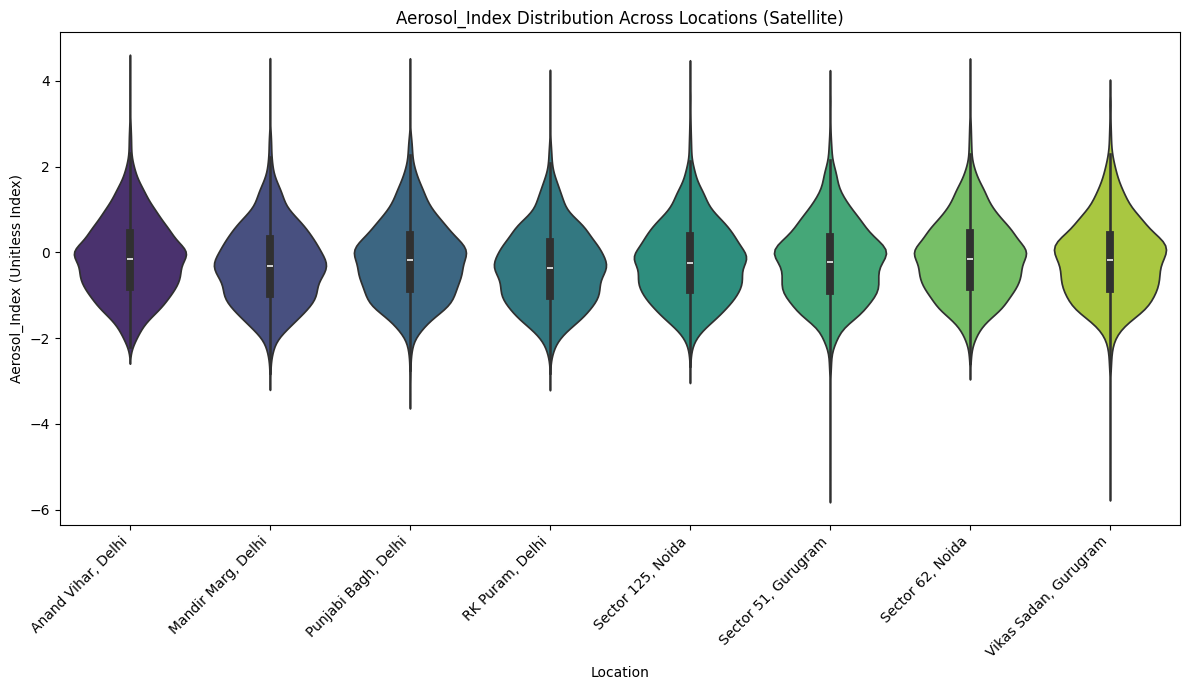

In [32]:
# Create a box plot for each pollutant
for col in pollutant_cols:
    if col in s5p_df.columns and pd.api.types.is_numeric_dtype(s5p_df[col]):
        plt.figure(figsize=(12, 7)) # Adjust size as needed
        sns.violinplot(data=s5p_df, x='location', y=col, palette='viridis')

        plt.title(f'{col} Distribution Across Locations (Satellite)')
        plt.xlabel('Location')
        plt.ylabel(f'{col} ({units.get(col, "")})')
        plt.xticks(rotation=45, ha='right') # Rotate labels for readability
        plt.tight_layout() # Adjust layout
        plt.show()
    else:
        print(f"Skipping {col} - Not Plotted (Non-numeric or Missing)")

## Observations: Pollutant Distributions Across Locations (Satellite Data)

The violin plots reveal variations in the distribution of satellite-measured pollutants across the different monitoring locations in Delhi NCR:

* **$NO_2$:**
    * All locations show distributions heavily skewed towards zero, indicating mostly low background levels.
    * **Anand Vihar, Punjabi Bagh, Mandir Marg, and Sector 62 (Noida)** exhibit noticeably longer tails extending to higher values compared to other locations like RK Puram, Sector 51 (Gurugram), and Vikas Sadan (Gurugram). This suggests more frequent or intense high $NO_2$ events captured by the satellite over these specific areas, potentially reflecting higher traffic or industrial activity influencing the atmospheric column.

* **$SO_2$:**
    * Similar to $NO_2$, the distributions are strongly right-skewed, concentrated near zero.
    * Longer tails indicating occasional higher values are visible across most locations, particularly prominent for **Sector 51 (Gurugram), Sector 62 (Noida), and Mandir Marg**. Anand Vihar also shows a significant tail.

* **$CO$:**
    * The distributions are more symmetrical than $NO_2$ or $SO_2$, but still show some right skewness (tails extending upwards).
    * Median values appear broadly similar across locations, generally hovering around 0.04 mol/m².
    * **Anand Vihar and Mandir Marg** might have slightly wider distributions and longer upper tails compared to the Gurugram locations.

* **$O_3$:**
    * Distributions are relatively symmetrical and bell-shaped across all locations.
    * Median values and overall shapes appear quite consistent, centered roughly around 0.125-0.13 mol/m². There isn't a dramatic difference in the typical total column ozone levels observed by the satellite between these sites.

* **Aerosol Index (AI):**
    * Distributions are fairly symmetrical around zero for all locations.
    * The spread (width of the violins) appears similar across most sites.
    * **Anand Vihar and Mandir Marg** possibly show slightly longer tails towards both positive and negative extremes compared to others like RK Puram or the Gurugram sites.

**Overall:** Locations known for higher ground-level pollution (like Anand Vihar) often show longer tails towards high values in the satellite data for pollutants like $NO_2$ and $SO_2$. $O_3$ distributions appear relatively uniform across the region from the satellite's perspective. $CO$ and Aerosol Index show moderate variability between locations. 


--- Plotting Time Series per Location ---


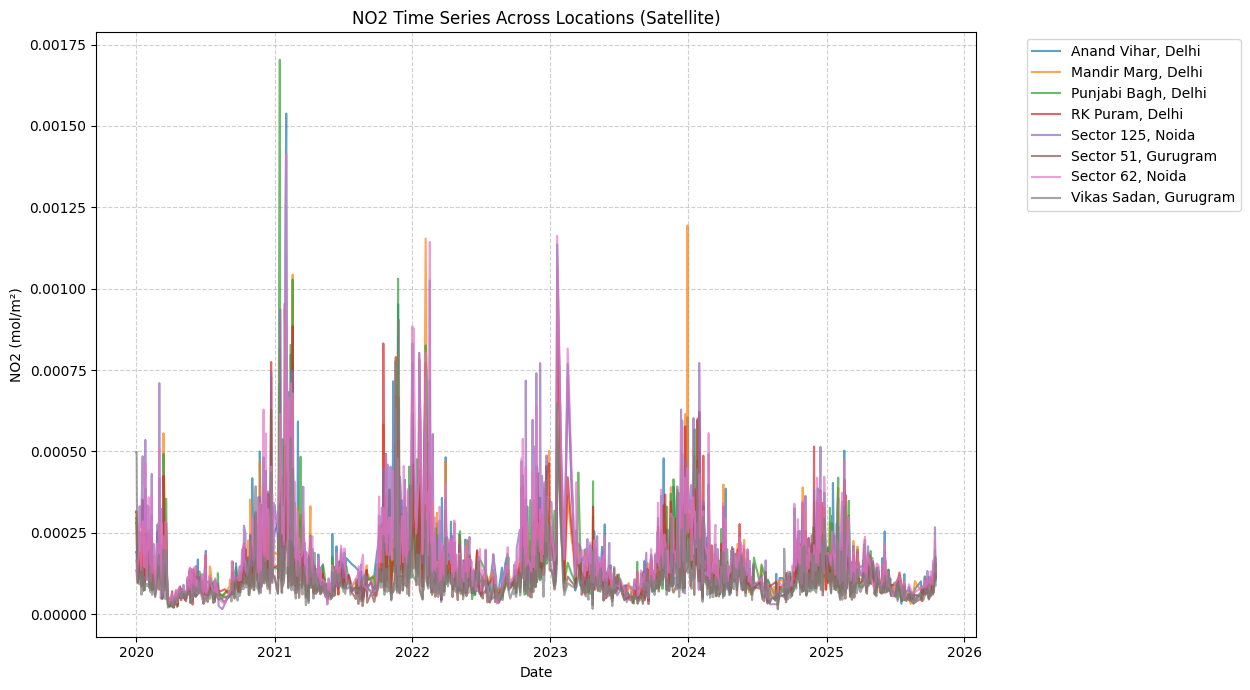

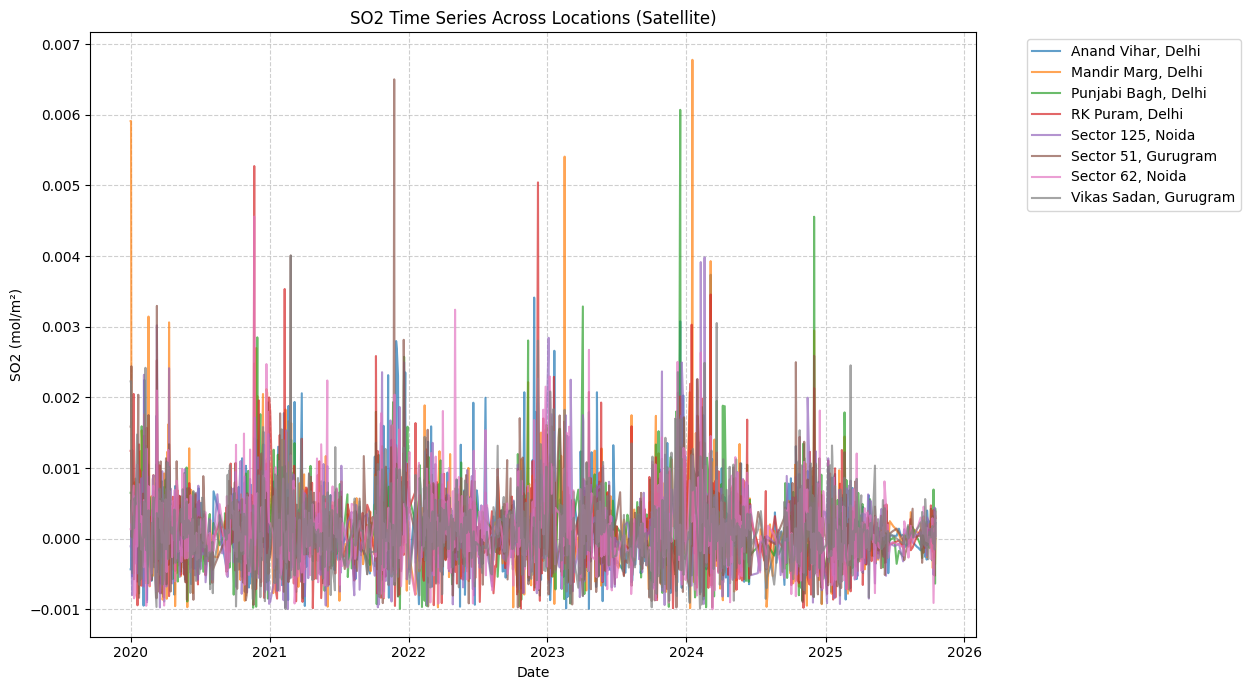

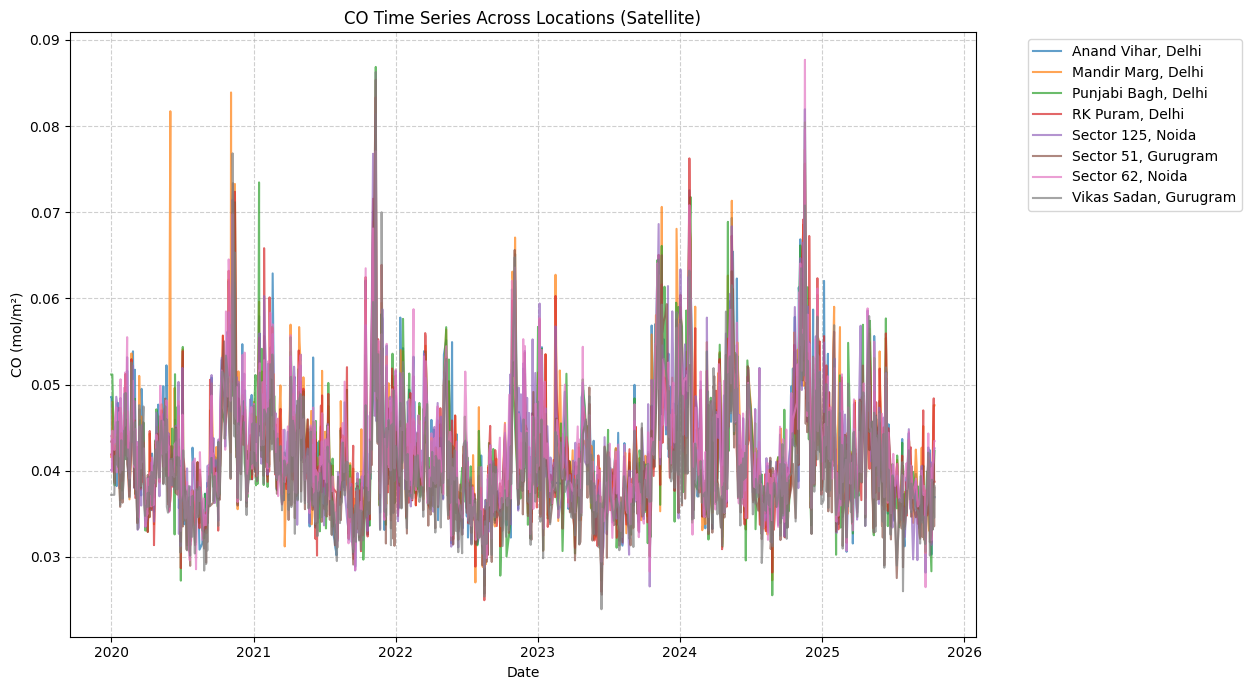

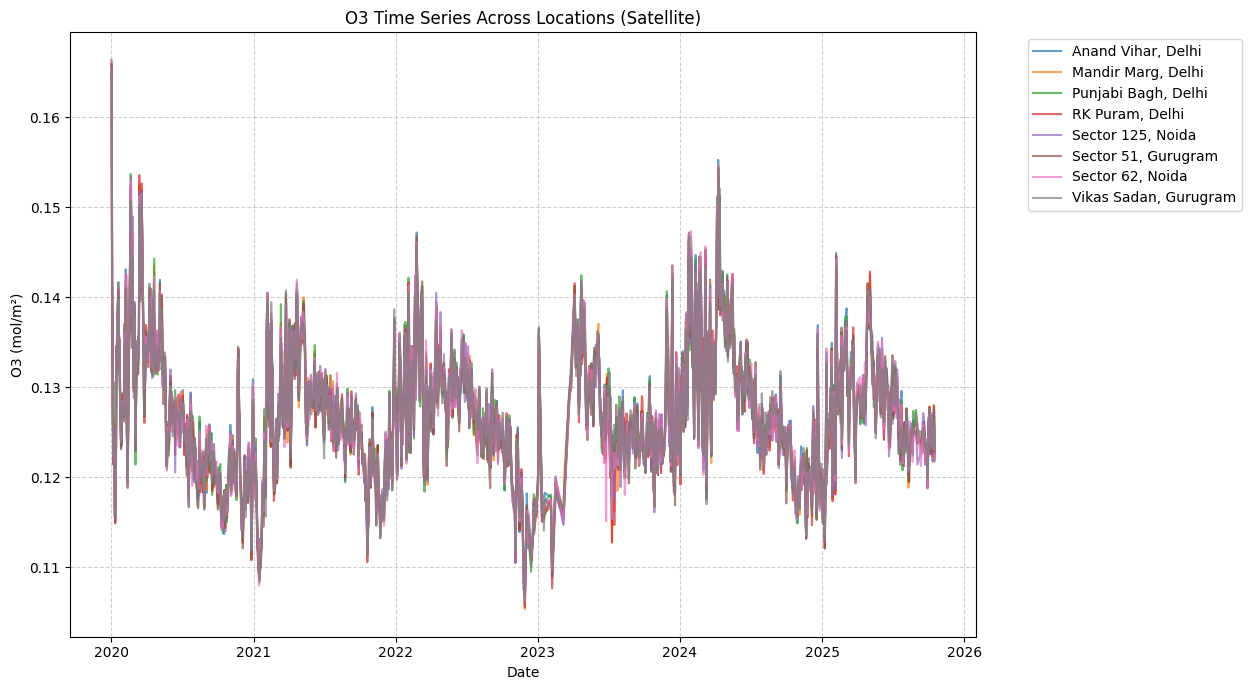

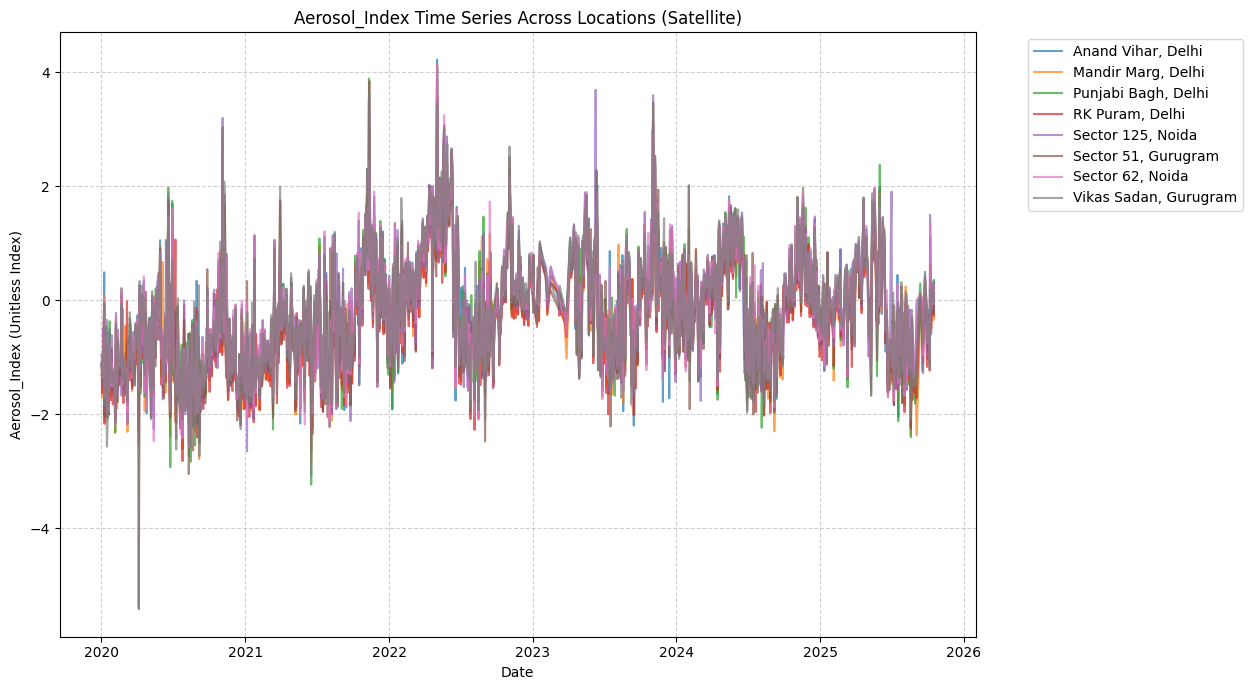

In [33]:
print("\n--- Plotting Time Series per Location ---")

# Get unique locations
locations = s5p_df['location'].unique()
pollutant_cols = ['NO2', 'SO2', 'CO', 'O3', 'Aerosol_Index']
units = {
    'NO2': 'mol/m²', 'SO2': 'mol/m²', 'CO': 'mol/m²',
    'O3': 'mol/m²', 'Aerosol_Index': 'Unitless Index'
}

# Plot each pollutant separately
for pollutant in pollutant_cols:
    if pollutant not in s5p_df.columns or not pd.api.types.is_numeric_dtype(s5p_df[pollutant]):
        print(f"Skipping {pollutant} - Not Plotted (Non-numeric or Missing)")
        continue

    plt.figure(figsize=(15, 7)) # Create a new figure for each pollutant

    # Plot the time series for each location on the same graph
    for location in locations:
        location_data = s5p_df[s5p_df['location'] == location]
        plt.plot(location_data['date'], location_data[pollutant], label=location, alpha=0.7)

    plt.title(f'{pollutant} Time Series Across Locations (Satellite)')
    plt.xlabel('Date')
    plt.ylabel(f'{pollutant} ({units.get(pollutant, "")})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    plt.show()

## Observations: Pollutant Time Series Across Locations (Satellite Data)

The time series plots show the daily variations of each satellite-measured pollutant from 2020 to late 2025 across all monitored locations:

* **$NO_2$:**
    * **Strong Seasonality:** Exhibits a very clear annual cycle with pronounced peaks during the winter months (roughly Oct-Jan) and much lower values during the monsoon season (roughly Jun-Sep). This pattern repeats consistently each year. 
    * **Peak Events:** The winter peaks vary in intensity year to year, with particularly high spikes visible around late 2020/early 2021 and late 2023.
    * **Location Differences:** While all locations follow the same seasonal pattern, the magnitude of the winter peaks differs. Locations like **Anand Vihar, Punjabi Bagh, Mandir Marg, and Sector 62 (Noida)** often show higher peak values compared to **RK Puram and the Gurugram sites**, aligning with the violin plot observations.
    * **Synchronization:** The rise and fall patterns are highly synchronized across all locations.

* **$SO_2$:**
    * **Less Clear Seasonality:** Shows significant variability and spikes, but a consistent annual seasonal pattern like $NO_2$ is less obvious. There might be slight increases during winter/post-monsoon periods.
    * **Spiky Nature:** Characterized by numerous sharp, short-duration peaks throughout the year, suggesting episodic events or localized sources significantly impacting the column density. Some major spikes occur in late 2023/early 2024.
    * **Location Differences:** Certain locations experience more intense spikes (e.g., **Mandir Marg, Sector 51, Sector 62** show some very high peaks at different times), but there isn't one location consistently higher than all others across the entire period.
    * **Synchronization:** Less synchronized than $NO_2$. While some major events seem to affect multiple locations, many peaks are localized.

* **$CO$:**
    * **Clear Seasonality:** Similar to $NO_2$, CO shows distinct seasonality with higher values during winter/post-monsoon (Oct-Jan/Feb) and lower values during monsoon (Jun-Sep).
    * **Peak Events:** Winter peaks are evident each year, with notable high periods in late 2020 and late 2023/early 2024.
    * **Location Differences:** All locations follow the seasonal trend, but **Anand Vihar and Mandir Marg** occasionally reach higher peak concentrations during winter compared to others.
    * **Synchronization:** The seasonal patterns are well synchronized across all locations.

* **$O_3$:**
    * **Distinct Seasonality (Opposite Trend):** Shows a clear annual cycle, but *opposite* to $NO_2$ and $CO$. Ozone levels peak during the pre-monsoon/summer months (roughly Mar-Jun) and are lowest during the monsoon and winter months. 
    * **Location Differences:** The patterns are remarkably consistent across all locations. There are minimal differences in the measured total column ozone between the sites throughout the year.
    * **Synchronization:** Very highly synchronized across all locations.

* **Aerosol Index (AI):**
    * **Seasonality Present:** Shows seasonal variations, typically peaking during the pre-monsoon/dust season (Apr-Jun) and having another period of elevated values post-monsoon/winter (Oct-Jan), likely related to haze and biomass burning. Values tend to be lower during the monsoon.
    * **High Variability:** Exhibits significant day-to-day fluctuations and spikes.
    * **Location Differences:** While the general seasonal pattern is similar, the magnitude and timing of peaks can vary between locations. **Anand Vihar and Mandir Marg** occasionally show higher positive peaks. Some locations show sharp negative dips at times.
    * **Synchronization:** Moderately synchronized, especially during major seasonal events (like dust storms or post-monsoon haze), but with considerable local variation.

**Overall:** $NO_2$, $CO$, and $O_3$ show strong, highly synchronized seasonal patterns across the region ($NO_2$/$CO$ peaking in winter, $O_3$ peaking in summer). $SO_2$ is much spikier and less seasonally distinct. Aerosol Index shows seasonality related to dust and haze events but also high variability. Location-specific differences are most apparent in the peak magnitudes of $NO_2$ and $SO_2$.


--- Plotting Correlation Matrix Heatmap ---


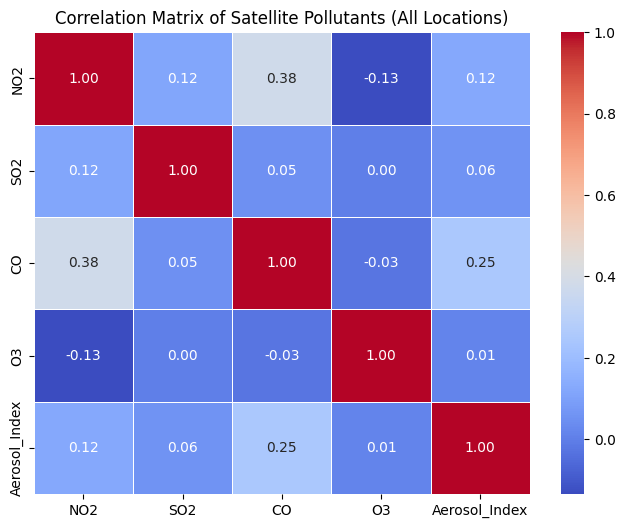


--- Correlation Matrix ---
                    NO2       SO2        CO        O3  Aerosol_Index
NO2            1.000000  0.117150  0.379001 -0.134447       0.124282
SO2            0.117150  1.000000  0.050278  0.001146       0.059455
CO             0.379001  0.050278  1.000000 -0.027890       0.246698
O3            -0.134447  0.001146 -0.027890  1.000000       0.013626
Aerosol_Index  0.124282  0.059455  0.246698  0.013626       1.000000


In [34]:
print("\n--- Plotting Correlation Matrix Heatmap ---")

pollutant_cols = ['NO2', 'SO2', 'CO', 'O3', 'Aerosol_Index']

# Select only the numeric pollutant columns
numeric_pollutant_df = s5p_df[pollutant_cols].select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_pollutant_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Satellite Pollutants (All Locations)')
plt.show()

print("\n--- Correlation Matrix ---")
print(correlation_matrix)

## Observations: Satellite Pollutant Correlation Matrix

The heatmap shows the Pearson correlation coefficients between the different satellite-measured pollutants across all locations and the entire time period:

* **Moderate Positive Correlation:**
    * **$NO_2$ and $CO$ (0.38):** These pollutants show the strongest positive relationship in the matrix. This is expected as both are often co-emitted from combustion sources (vehicles, industry). 

* **Weak Positive Correlations:**
    * **$CO$ and Aerosol Index (0.25):** A weak positive association, suggesting that higher CO sometimes coincides with higher aerosol levels, potentially during haze events or biomass burning.
    * **$NO_2$ and Aerosol Index (0.12):** Very weak positive correlation.
    * **$NO_2$ and $SO_2$ (0.12):** Very weak positive correlation.
    * **$SO_2$ and Aerosol Index (0.06):** Negligible positive correlation.
    * **$SO_2$ and $CO$ (0.05):** Negligible positive correlation.

* **Weak Negative Correlations:**
    * **$NO_2$ and $O_3$ (-0.13):** A weak negative correlation. This is chemically plausible, as high $NO_x$ (which includes $NO_2$) can sometimes deplete ozone locally, especially under specific atmospheric conditions (like high $NO_x$ titration in winter).
    * **$CO$ and $O_3$ (-0.03):** Negligible negative correlation.

* **Near-Zero Correlations:**
    * **$SO_2$ and $O_3$ (0.00):** Essentially no linear correlation.
    * **$O_3$ and Aerosol Index (0.01):** Essentially no linear correlation.

**Overall:** The strongest link observed in the satellite data is between $NO_2$ and $CO$. Ozone shows a weak negative correlation with $NO_2$. Most other pairings show very weak or negligible linear relationships when considering the entire dataset across all locations. This suggests complex interactions rather than simple, strong linear dependencies between most of these column measurements.